In [1]:
# multivariate multi-headed 1d cnn example

from numpy import array
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
import math
from keras.layers import ConvLSTM2D
import matplotlib.pyplot as plt
from numpy import hstack
import numpy as np
from keras.layers import Dropout
from keras.layers import GRU
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard
import keras.layers
import pandas as pd
from  keras.layers import Bidirectional
from scipy import signal
import scipy
#dataları 1d cnn yapısı için uygun boyuta getirir
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y1,y2 = list(), list(),list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y1,seq_y2 = sequences[i:end_ix, :-2], sequences[end_ix-1, -2],sequences[end_ix-1, -1]
		X.append(seq_x)
		y1.append(seq_y1)
		y2.append(seq_y2)
	return array(X), array(y1),array(y2)



In [2]:
#dosyadaki imu datalarını oku(train dataset)

s1=pd.read_csv('data_inert1.txt',  delimiter= '\s+', index_col=False, header=None)
#s1 = s1.truncate(before=725,after=14827-u)
s2=pd.read_csv('data_inert2.txt', delimiter= '\s+', index_col=False, header=None)
#s2 = s2.truncate(before=922,after=14471-u)
s3=pd.read_csv('data_inert3.txt' , delimiter= '\s+', index_col=False, header=None)
#s3 = s3.truncate(before=729,after=15037-u)
s4=pd.read_csv('data_inert4.txt',  delimiter= '\s+', index_col=False, header=None)
#s4 = s4.truncate(before=503,after=14748-u)
s5=pd.read_csv('data_inert5.txt',  delimiter= '\s+', index_col=False, header=None)
#s5 = s5.truncate(before=655,after=14865-u)
s6=pd.read_csv('data_inert6.txt', delimiter= '\s+', index_col=False, header=None)
#s6 = s6.truncate(before=678,after=15375-u)
s7=pd.read_csv('data_inert7.txt' , delimiter= '\s+', index_col=False, header=None) #test dataset
#s7 = s7.truncate(before=708,after=15040-u)
s8=pd.read_csv('data_inert8.txt',  delimiter= '\s+', index_col=False, header=None)
#s8 = s8.truncate(before=633,after=14544-u)
s9=pd.read_csv('data_inert9.txt',  delimiter= '\s+', index_col=False, header=None)
#s9 = s9.truncate(before=563,after=15357-u)
s10=pd.read_csv('data_inert10.txt', delimiter= '\s+', index_col=False, header=None)
#s10 = s10.truncate(before=527,after=14921-u)
s11=pd.read_csv('data_inert11.txt' , delimiter= '\s+', index_col=False, header=None)
#s11 = s11.truncate(before=523,after=15297-u)
s12=pd.read_csv('data_inert12.txt',  delimiter= '\s+', index_col=False, header=None)
#s12 = s12.truncate(before=560,after=15204-u)
s13=pd.read_csv('data_inert13.txt',  delimiter= '\s+', index_col=False, header=None)
#s13 = s13.truncate(before=672,after=11371-u)

#dataları birlerştir(train dataset)
dat=pd.concat([s1,s2,s3,s4,s5,s6,s8,s9,s10,s11,s12,s13], ignore_index=True)
dattest=pd.concat([s7], ignore_index=True)#test dataset
data1=dat[[1]]
data2=dat[[2]]
data3=dat[[3]]
data4=dat[[4]]
data5=dat[[5]]
data6=dat[[6]]




#test datasette gerekli kısmı seçiyoruz.  1,2,3 numaralı kolonlar ax,ay,az.  4,5,6 numaralı kolonlar gx,gy,gz(test dataset son hali)
data1test=dattest[[1]]
data2test=dattest[[2]]
data3test=dattest[[3]]
data4test=dattest[[4]]
data5test=dattest[[5]]
data6test=dattest[[6]]




In [3]:
#train ve test dataları numpy vektöre a çeviriyoruz
in_seq1=data1.to_numpy()
in_seq2=data2.to_numpy()
in_seq3=data3.to_numpy()
in_seq4=data4.to_numpy()
in_seq5=data5.to_numpy()
in_seq6=data6.to_numpy()

in_seq1t=data1test.to_numpy()
in_seq2t=data2test.to_numpy()
in_seq3t=data3test.to_numpy()
in_seq4t=data4test.to_numpy()
in_seq5t=data5test.to_numpy()
in_seq6t=data6test.to_numpy()
qq1=pd.read_csv('resp1.csv')
qq2=pd.read_csv('resp2.csv')
qq3=pd.read_csv('resp3.csv')
qq4=pd.read_csv('resp4.csv')
qq5=pd.read_csv('resp5.csv')
qq6=pd.read_csv('resp6.csv')
qq7=pd.read_csv('resp7.csv')
qq8=pd.read_csv('resp8.csv')
qq9=pd.read_csv('resp9.csv')
qq10=pd.read_csv('resp10.csv')
qq11=pd.read_csv('resp11.csv')
qq12=pd.read_csv('resp12.csv')
qq13=pd.read_csv('resp13.csv')
yyas=pd.concat([qq1,qq2,qq3,qq4,qq5,qq6,qq8,qq9,qq10,qq11,qq12,qq13], ignore_index=True) # train dataları birleştir
yyast=pd.concat([qq7], ignore_index=True)# test dataları birleştir

yyayawt=yyast[['9']]#test target gerekli kısmı seçiyoruz.  1,2,9 numaralı kolonlar pos x, pos y,  yaw (test target son hali)

yyayaw=yyas[['9']]#train target gerekli kısmı seçiyoruz.  1,2,9 numaralı kolonlar pos x, pos y,  yaw (train target son hali)

yyxtests=yyast[['1','2']]#test target gerekli kısmı seçiyoruz.  1,2,9 numaralı kolonlar pos x, pos y,  yaw (test target son hali)

yyxs=yyas[['1','2']]#train target gerekli kısmı seçiyoruz.  1,2,9 numaralı kolonlar pos x, pos y,  yaw (train target son hali)

#target ları numpy vektöre çevir
yyxyaw=yyayaw.to_numpy()
yyxyawt=yyayawt.to_numpy()

yyxs=yyxs.to_numpy()
yyxtests=yyxtests.to_numpy()



#target data oku
q1=pd.read_csv('pseudoGTt1.csv')
q2=pd.read_csv('pseudoGTt2.csv')
q3=pd.read_csv('pseudoGTt3.csv')
q4=pd.read_csv('pseudoGTt4.csv')
q5=pd.read_csv('pseudoGTt5.csv')
q6=pd.read_csv('pseudoGTt6.csv')
q7=pd.read_csv('pseudoGTt7.csv')
q8=pd.read_csv('pseudoGTt8.csv')
q9=pd.read_csv('pseudoGTt9.csv')
q10=pd.read_csv('pseudoGTt10.csv')
q11=pd.read_csv('pseudoGTt11.csv')
q12=pd.read_csv('pseudoGTt12.csv')
q13=pd.read_csv('pseudoGTt13.csv')


#q7.loc[0:707, ['1','2']]=[0,0]

yya=pd.concat([q1,q2,q3,q4,q5,q6,q8,q9,q10,q11,q12,q13], ignore_index=True)
yyatest=pd.concat([q7], ignore_index=True)
yyatest=yyatest[['1','2']]
yya=yya[['1','2']]
yya['2'] = yya['2'].fillna(0)
yyatest['2'] = yyatest['2'].fillna(0)
yyatest.tail()

#test_df.loc[250:400, ['B', 'C']]


,1,2
16536,0.000126,0.000002
16537,0.000126,0.000002
16538,0.000126,0.000002
16539,0.000126,0.000002
16540,0.000126,0.000002


In [4]:

from scipy.signal import filtfilt

n = 150 # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
wet= filtfilt(b, a, yyxyawt[:,0])
we= filtfilt(b, a, yyxyaw[:,0])


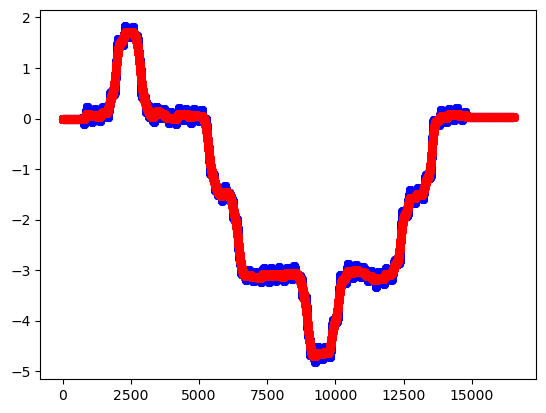

In [5]:

arr = np.arange(0,len(wet))
plt.scatter(arr,yyxyawt,linewidth=0.5, linestyle="-", c="b")
plt.scatter(arr,wet,linewidth=0.5, linestyle="-", c="r")


In [6]:
#target ları numpy vektöre çevir
yyx=yya.to_numpy()
yyxtest=yyatest.to_numpy()

#yyxyawt[:,0]=wet[:]
#yyxyaw[:,0]=we[:]

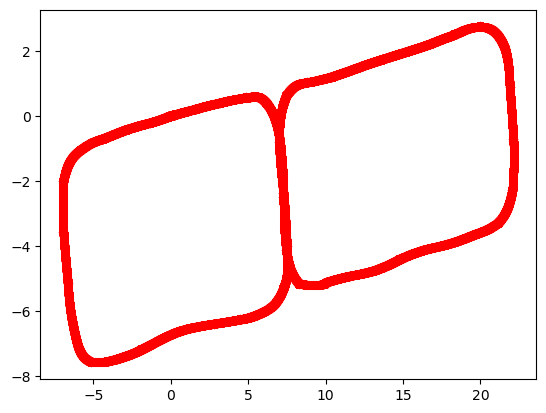

In [7]:
plt.scatter(yyxtest[:,1],yyxtest[:,0],linewidth=0.5, linestyle="-", c="r")

In [ ]:
yyxyawt.shape

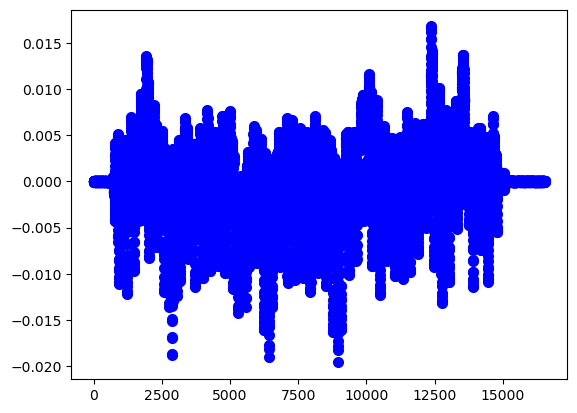

In [8]:







from scipy.signal import lfilter
from scipy.signal import filtfilt
#filter-------------------------------------------------------------------------------------
n = 120 # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1

n1 = 10 # the larger n is, the smoother curve will be
b1 = [1.0 / n1] * n1
a1 = 1

n2 = 3  # the larger n is, the smoother curve will be
b2 = [1.0 / n2] * n2
a2 = 1
'''

in_seq1= filtfilt(b1, a1, in_seq1[:,0])
in_seq2=filtfilt(b1, a1, in_seq2[:,0])
in_seq3=filtfilt(b1, a1, in_seq3[:,0])
in_seq4=filtfilt(b1, a1, in_seq4[:,0])
in_seq5=filtfilt(b1, a1, in_seq5[:,0])
in_seq6=filtfilt(b1, a1, in_seq6[:,0])

in_seq1t=filtfilt(b1, a1, in_seq1t[:,0])
in_seq2t=filtfilt(b1, a1, in_seq2t[:,0])
in_seq3t=filtfilt(b1, a1, in_seq3t[:,0])
in_seq4t=filtfilt(b1, a1, in_seq4t[:,0])
in_seq5t=filtfilt(b1, a1, in_seq5t[:,0])
in_seq6t=filtfilt(b1, a1, in_seq6t[:,0])
'''
#yyxtest[:,1] = lfilter(b, a, yyxtest[:,1])
#yyxtest[:,0] = lfilter(b, a, yyxtest[:,0])
yyxtest[:,1] = filtfilt(b, a, yyxtest[:,1])
yyxtest[:,0] = filtfilt(b, a, yyxtest[:,0])
#yyxyaw = lfilter(b2, a2, yyxyaw)
#yyx[:,1] = lfilter(b, a, yyx[:,1])
#yyx[:,0] = lfilter(b, a, yyx[:,0])
yyx[:,1] = filtfilt(b, a, yyx[:,1])
yyx[:,0] = filtfilt(b, a, yyx[:,0])
#yyxyawt = lfilter(b2, a2, yyxyawt)




#train datada deltaposition normunu hesaplar. bunu target olarak kullanacağız
f=yyx.shape
a=np.zeros((f[0], 2))
ttt=0
for i in range(f[0]-1):
    a[i,0]=math.sqrt((yyx[i+1,0]-yyx[i,0])**2+(yyx[i+1,1]-yyx[i,1])**2)
    a[i,1]=math.atan2(yyx[i+1,1]-yyx[i,1],yyx[i+1,0]-yyx[i,0])
#a[:,1]=yyxyaw[:]

a[:,1]=np.unwrap(a[:,1], period=2*math.pi) 
a[:,1]=yyxyaw[:,0]
#a[:,1]=yyxyaw[:,0]
#a[:,1]=a[:,1]-math.pi/2  
#----------------------------
#f=yyx.shape
#dmag=np.zeros((f[0], 1))
#ttt=0
#for i in range(f[0]-1):
#    dmag[i,0]=a[i+1,0]-a[i,0]

#test datada deltaposition normunu hesaplar. bunu normu tahmin etmek çin target olarak kullanacağız

f=yyxtest.shape
at=np.zeros((f[0], 2))
for i in range(f[0]-1):
    at[i,0]=math.sqrt((yyxtest[i+1,0]-yyxtest[i,0])**2+(yyxtest[i+1,1]-yyxtest[i,1])**2)
    at[i,1]=math.atan2(yyxtest[i+1,1]-yyxtest[i,1],yyxtest[i+1,0]-yyxtest[i,0])
at[:,1]=np.unwrap(at[:,1], period=2*math.pi) 
at[:,1]=yyxyawt[:,0]
#at[:,1]=yyxyawt[:]
#---------------------
#at[:,1]=yyxyawt[:,0]
#at[:,1]=at[:,1]-math.pi/2  
arr = np.arange(0,len(at))
f=at.shape
rrt=np.zeros((f[0], 1))
for i in range(f[0]-1):
    rrt[i,0]=at[i+1,1]-at[i,1]

for i in range(f[0]-1):
    if rrt[i,0]>0.02 or rrt[i,0]<-0.02:
        rrt[i,0]=0

#train datada deltayaw hesaplar. bunu heading i tahmin etmek için target olarak kullanacağız
yyp=a.shape
rr=np.zeros((yyp[0], 1))
for i in range(yyp[0]-1):
    rr[i,0]=a[i+1,1]-a[i,1]

for i in range(yyp[0]-1):
    if rr[i,0]>0.02 or rr[i,0]<-0.02:
        rr[i,0]=0.0

#at[0:707,:]=1.43304571
#at[15268:,:]=1.42737779
arr = np.arange(0,len(rrt))
plt.scatter(arr[:],rrt[:,0],linewidth=2, linestyle="-", c="b")


In [91]:
yyxtest.shape

(16541, 2)

In [92]:
at.shape

(16541, 2)

In [94]:
rrt.shape

(16541, 1)

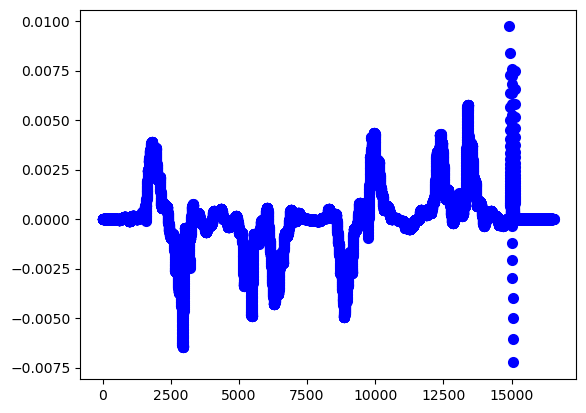

In [9]:
f=yyxtest.shape
ct=np.zeros((f[0], 2))
for i in range(f[0]-1):
    ct[i,0]=math.sqrt((yyxtest[i+1,0]-yyxtest[i,0])**2+(yyxtest[i+1,1]-yyxtest[i,1])**2)
    ct[i,1]=math.atan2(yyxtest[i+1,1]-yyxtest[i,1],yyxtest[i+1,0]-yyxtest[i,0])
ct[:,1]=np.unwrap(ct[:,1], period=2*math.pi) 
#at[:,1]=yyxyawt[:]
#---------------------
#at[:,1]=yyxyawt[:,0]
#at[:,1]=at[:,1]-math.pi/2  
arr = np.arange(0,len(at))
f=at.shape
rct=np.zeros((f[0], 1))
for i in range(f[0]-1):
    rct[i,0]=ct[i+1,1]-ct[i,1]

for i in range(f[0]-1):
    if rct[i,0]>0.01 or rct[i,0]<-0.01:
        rct[i,0]=0

#at[0:707,:]=1.43304571
#at[15268:,:]=1.42737779
arr = np.arange(0,len(rct))
plt.scatter(arr[:],rct[:,0],linewidth=2, linestyle="-", c="b")


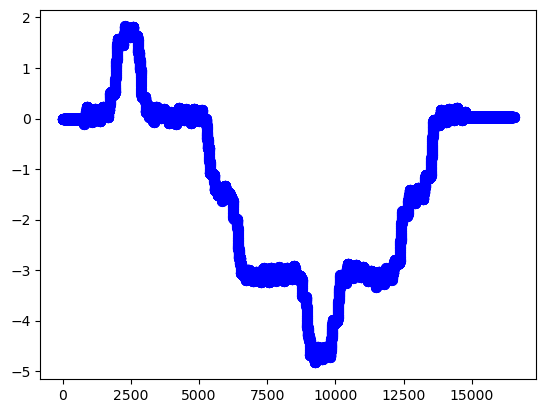

In [10]:


arr = np.arange(0,len(at[:,1]))
plt.scatter(arr,at[:,1],linewidth=2, linestyle="-", c="b")

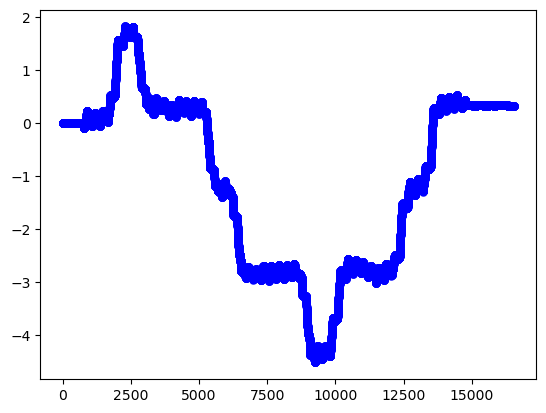

In [11]:
#ccc=1.43304571497088
#original heading is used
ccc=0

arr = np.arange(0,len(rrt))
xxrt=np.zeros(len(rrt))

for i in arr:
    xxrt[i]=ccc+rrt[i]
    
    ccc=xxrt[i]
arr = np.arange(0,len(xxrt))




plt.scatter(arr[:],xxrt,linewidth=0.1, linestyle="-", c="b")    

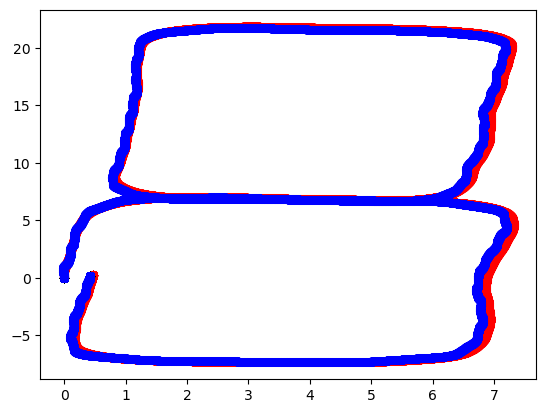

In [47]:
'''
f=yyxtest.shape
ht=np.zeros((f[0], 2))
for i in range(f[0]-1):
    ht[i,0]=math.sqrt((yyxtest[i+1,0]-yyxtest[i,0])**2+(yyxtest[i+1,1]-yyxtest[i,1])**2)
ht[:,1]=wet
#at[:,1]=yyxyawt[:]
#---------------------
#at[:,1]=yyxyawt[:,0]
#at[:,1]=at[:,1]-math.pi/2  
arr = np.arange(0,len(at))
f=at.shape
hct=np.zeros((f[0], 1))
for i in range(f[0]-1):
   hct[i,0]=ht[i+1,1]-ht[i,1]



#ccc=1.43304571497088
#original heading is used
ccc=0

arr = np.arange(0,len(hct))
tur=np.zeros(len(hct))

for i in arr:
    tur[i]=ccc+hct[i]
    
    ccc=tur[i]
arr = np.arange(0,len(tur))


#bu kısım oluşturulan target data(pos.norm,heading) matlabdaki çıktıyı veriyormu diye baktık. biraz farklı sonuç verdi. 
#xxrt=yyxyawt
arr = np.arange(0,len(tur))
sxr=np.zeros(len(tur))
syr=np.zeros(len(tur))

for i in arr:
    sxr[i]=ht[i,0]*math.cos(tur[i])
    syr[i]=ht[i,0]*math.sin(tur[i])

ddd=0
vvv=0
arr = np.arange(0,len(sxr))
xfty=np.zeros((len(sxr),2))


for i in arr:
    xfty[i,0]=ddd+sxr[i]
    xfty[i,1]=vvv+syr[i]
    
    ddd=xfty[i,0]
    vvv=xfty[i,1]








xxrt=yyxyawt
#yaw ve normu kullanarak x,y yi hesaplayıp çizdiriyoruz
arr = np.arange(0,len(xxrt))
sx=np.zeros(len(xxrt))
sy=np.zeros(len(xxrt))

for i in arr:
    sx[i]=at[i,0]*math.cos(xxrt[i])
    sy[i]=at[i,0]*math.sin(xxrt[i])

ddd=0
vvv=0
arr = np.arange(0,len(sx))
xsft=np.zeros((len(sx),2))


for i in arr:
    xsft[i,0]=ddd+sx[i]
    xsft[i,1]=vvv+sy[i]
    
    ddd=xsft[i,0]
    vvv=xsft[i,1]
plt.scatter(xfty[:,1],xfty[:,0],linewidth=0.5, linestyle="-", c="r")

plt.scatter(xsft[:,1],xsft[:,0],linewidth=0.5, linestyle="-", c="b")

In [61]:
xxrt[0]

3.23858042987516e-05

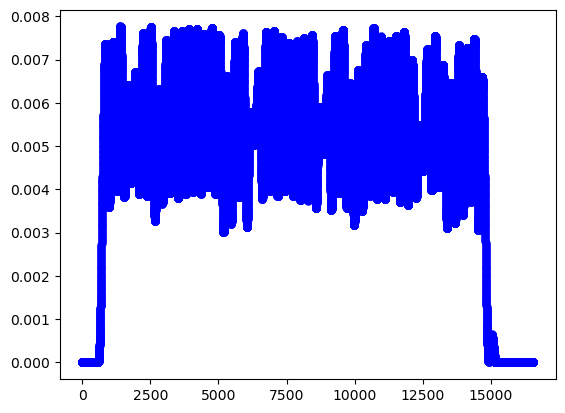

In [12]:
arr = np.arange(0,len(at[:,0]))
plt.scatter(arr[:],at[:,0],linewidth=0.1, linestyle="-", c="b")

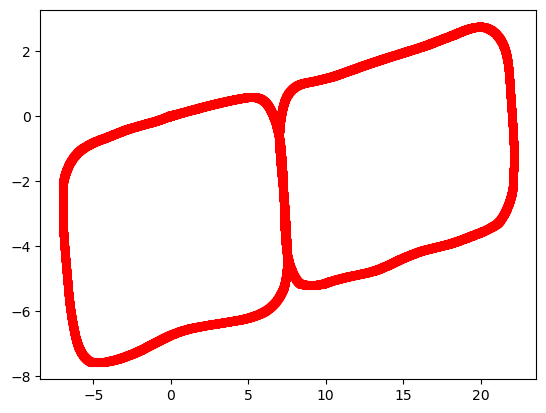

In [13]:
plt.scatter(yyxtest[:,1],yyxtest[:,0],linewidth=0.5, linestyle="-", c="r")

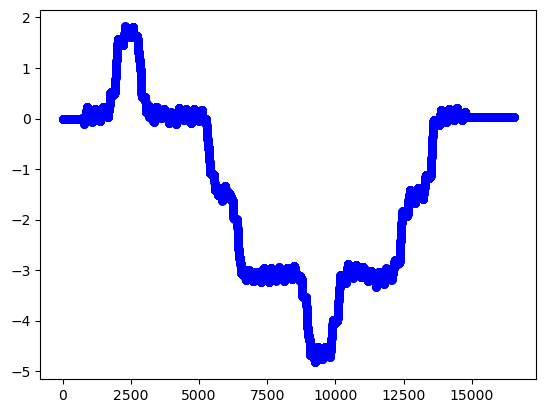

In [14]:
arr = np.arange(0,len(at))
plt.scatter(arr[:],at[:,1],linewidth=0.1, linestyle="-", c="b")

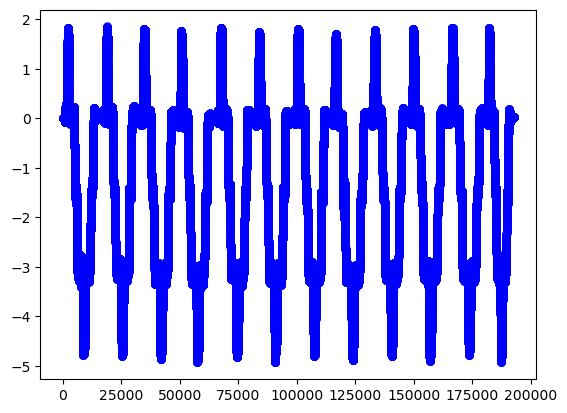

In [15]:
arr = np.arange(0,len(a))
plt.scatter(arr[:],a[:,1],linewidth=0.1, linestyle="-", c="b")

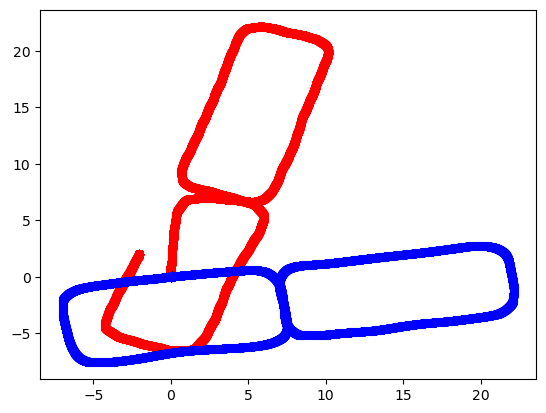

In [16]:
#bu kısım oluşturulan target data(pos.norm,heading) matlabdaki çıktıyı veriyormu diye baktık. biraz farklı sonuç verdi. 
#xxrt=yyxyawt
arr = np.arange(0,len(xxrt))
sx=np.zeros(len(xxrt))
sy=np.zeros(len(xxrt))

for i in arr:
    sx[i]=at[i,0]*math.cos(xxrt[i])
    sy[i]=at[i,0]*math.sin(xxrt[i])

ddd=0
vvv=0
arr = np.arange(0,len(sx))
xft=np.zeros((len(sx),2))


for i in arr:
    xft[i,0]=ddd+sx[i]
    xft[i,1]=vvv+sy[i]
    
    ddd=xft[i,0]
    vvv=xft[i,1]

plt.scatter(xft[:,1],xft[:,0],linewidth=0.5, linestyle="-", c="r")

plt.scatter(yyxtest[:,1],yyxtest[:,0],linewidth=0.5, linestyle="-", c="b")

In [17]:



#verileri(test, train target) 1 boyutlu vektör haline getiriyoruz.

out_seq1 = a[:,0]
out_seq2 = rr
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))

out_seq1 = out_seq1.reshape((len(out_seq1), 1))
out_seq2 = out_seq2.reshape((len(out_seq2), 1))


In [18]:

out_seqt1 = at[:,0]
out_seqt2 = rrt
# convert to [rows, columns] structure
in_seq1t = in_seq1t.reshape((len(in_seq1t), 1))
in_seq2t = in_seq2t.reshape((len(in_seq2t), 1))
in_seq3t = in_seq3t.reshape((len(in_seq3t), 1))
in_seq4t = in_seq4t.reshape((len(in_seq4t), 1))
in_seq5t = in_seq5t.reshape((len(in_seq5t), 1))
in_seq6t = in_seq6t.reshape((len(in_seq6t), 1))

out_seqt1 = out_seqt1.reshape((len(out_seqt1), 1))
out_seqt2 = out_seqt2.reshape((len(out_seqt2), 1))




In [99]:
in_seq1t.shape

(16541, 1)

In [ ]:
'''
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
true_predictions = scaler.inverse_transform(test_predictions)
'''

In [19]:
# oluşturduumuz dikey datayı birleştiriyoruz
dataset = hstack((in_seq1, in_seq2,in_seq3,in_seq4, in_seq5,in_seq6 ,out_seq1, out_seq2))

datasettest = hstack((in_seq1t,in_seq2t,in_seq3t,in_seq4t,in_seq5t,in_seq6t, out_seqt1,out_seqt2))


In [20]:
# choose a number of time steps(pencere boyutu)
n_steps = 48

In [21]:
# test ve train dataları window size ı kullanarak 1d cnn e uygun hale getiriyoruz.
X, y1,y2 = split_sequences(dataset, n_steps)
Xt, yt1,yt2 = split_sequences(datasettest, n_steps)

# one time series per head
n_features = 1
X.shape


(192572, 48, 6)

In [ ]:
'''''
from sklearn.preprocessing import MinMaxScaler
import numpy as np

class MinMaxScaler3D(MinMaxScaler):

    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)
''''

In [ ]:
#scaler = MinMaxScaler3D()
#X = scaler.fit_transform(X)
#Xt = scaler.fit_transform(Xt)

In [22]:
# separate input data
X1 = X[:, :, 0].reshape(X.shape[0], X.shape[1], n_features)
X2 = X[:, :, 1].reshape(X.shape[0], X.shape[1], n_features)
X3 = X[:, :, 2].reshape(X.shape[0], X.shape[1], n_features)
X4 = X[:, :, 3].reshape(X.shape[0], X.shape[1], n_features)
X5 = X[:, :, 4].reshape(X.shape[0], X.shape[1], n_features)
X6 = X[:, :, 5].reshape(X.shape[0], X.shape[1], n_features)
X1t = Xt[:, :, 0].reshape(Xt.shape[0], Xt.shape[1], n_features)
X2t = Xt[:, :, 1].reshape(Xt.shape[0], Xt.shape[1], n_features)
X3t = Xt[:, :, 2].reshape(Xt.shape[0], Xt.shape[1], n_features)
X4t = Xt[:, :, 3].reshape(Xt.shape[0], Xt.shape[1], n_features)
X5t = Xt[:, :, 4].reshape(Xt.shape[0], Xt.shape[1], n_features)
X6t = Xt[:, :, 5].reshape(Xt.shape[0], Xt.shape[1], n_features)


In [ ]:
'''
inputax = Input(shape=(n_steps, n_features))
inputay = Input(shape=(n_steps, n_features))
inputaz = Input(shape=(n_steps, n_features))
inputwx = Input(shape=(n_steps, n_features))
inputwy = Input(shape=(n_steps, n_features))
inputwz = Input(shape=(n_steps, n_features))
act_func='LeakyReLU'
filter1=1024
filter2=512
k_size1=24
k_size2=16
mp1=8
mp2=4
# first input model
cnn1 = Conv1D(filters=filter1, kernel_size=k_size1, activation=act_func,padding='SAME')(inputax)
cnn1 = MaxPooling1D(pool_size=mp1)(cnn1)
keras.layers.BatchNormalization(),
cnn1=Dropout(0.5)(cnn1)
cnn1 = Conv1D(filters=filter2, kernel_size=k_size2, activation=act_func,padding='SAME')(cnn1)
cnn1 = MaxPooling1D(pool_size=mp2,padding='SAME')(cnn1)
keras.layers.BatchNormalization(),
cnn1=Dropout(0.5)(cnn1)
#cnn1= GRU (32,dropout=0.5,recurrent_dropout=0.5)(cnn1)
cnn1 = Flatten()(cnn1)
cnn1 = Model(inputs=inputax, outputs=cnn1)

# second input model
cnn2 = Conv1D(filters=filter1, kernel_size=k_size1, activation=act_func,padding='SAME')(inputay)
cnn2 = MaxPooling1D(pool_size=mp1)(cnn2)
keras.layers.BatchNormalization(),
cnn2=Dropout(0.5)(cnn2)
cnn2 = Conv1D(filters=filter2, kernel_size=k_size2, activation=act_func,padding='SAME')(cnn2)
cnn2 = MaxPooling1D(pool_size=mp2,padding='SAME')(cnn2)
keras.layers.BatchNormalization(),
cnn2=Dropout(0.5)(cnn2)
#3cnn2= GRU (32,dropout=0.5,recurrent_dropout=0.5)(cnn2)
cnn2 = Flatten()(cnn2)
cnn2 = Model(inputs=inputay, outputs=cnn2)



cnn3 = Conv1D(filters=filter1, kernel_size=k_size1, activation=act_func,padding='SAME')(inputaz)
cnn3 = MaxPooling1D(pool_size=mp1)(cnn3)
keras.layers.BatchNormalization(),
cnn3=Dropout(0.5)(cnn3)
cnn3 = Conv1D(filters=filter2, kernel_size=k_size2, activation=act_func,padding='SAME')(cnn3)
cnn3 = MaxPooling1D(pool_size=mp2,padding='SAME')(cnn3)
keras.layers.BatchNormalization(),
cnn3=Dropout(0.5)(cnn3)
#cnn3= GRU (32,dropout=0.5,recurrent_dropout=0.5)(cnn3)
cnn3 = Flatten()(cnn3)
cnn3 = Model(inputs=inputaz, outputs=cnn3)

#---------------yaw--------------------------------------------------------------------

# first input model
cnn4 = Conv1D(filters=filter1, kernel_size=k_size1, activation=act_func,padding='SAME')(inputwx)
cnn4 = MaxPooling1D(pool_size=mp1)(cnn4)
keras.layers.BatchNormalization(),
cnn4=Dropout(0.5)(cnn4)
cnn4 = Conv1D(filters=filter2, kernel_size=k_size2, activation=act_func,padding='SAME')(cnn4)
cnn4 = MaxPooling1D(pool_size=mp2,padding='SAME')(cnn4)
keras.layers.BatchNormalization(),
cnn4=Dropout(0.5)(cnn4)
#cnn4= GRU (32,dropout=0.5,recurrent_dropout=0.5)(cnn4)
cnn4 = Flatten()(cnn4)
cnn4 = Model(inputs=inputwx, outputs=cnn4)



# second input model

cnn5 = Conv1D(filters=filter1, kernel_size=k_size1, activation=act_func,padding='SAME')(inputwy)
cnn5 = MaxPooling1D(pool_size=mp1)(cnn5)
keras.layers.BatchNormalization(),
cnn5=Dropout(0.5)(cnn5)
cnn5 = Conv1D(filters=filter2, kernel_size=k_size2, activation=act_func,padding='SAME')(cnn5)
cnn5 = MaxPooling1D(pool_size=mp2,padding='SAME')(cnn5)
keras.layers.BatchNormalization(),
cnn5=Dropout(0.5)(cnn5)
#cnn5= GRU (32,dropout=0.5,recurrent_dropout=0.5)(cnn5)
cnn5 = Flatten()(cnn5)
cnn5 = Model(inputs=inputwy, outputs=cnn5)



cnn6 = Conv1D(filters=filter1, kernel_size=k_size1, activation=act_func,padding='SAME')(inputwz)
cnn6 = MaxPooling1D(pool_size=mp1)(cnn6)
keras.layers.BatchNormalization(),
cnn6=Dropout(0.5)(cnn6)
cnn6 = Conv1D(filters=filter2, kernel_size=k_size2, activation=act_func,padding='SAME')(cnn6)
cnn6 = MaxPooling1D(pool_size=mp2,padding='SAME')(cnn6)
keras.layers.BatchNormalization(),
cnn6=Dropout(0.5)(cnn6)
#cnn6= GRU (32,dropout=0.5,recurrent_dropout=0.5)(cnn6)
cnn6 = Flatten()(cnn6)
cnn6= Model(inputs=inputwz, outputs=cnn6)


# merge input models
merge1 = concatenate([cnn1.output,cnn2.output,cnn3.output])
merge2 = concatenate([cnn4.output,cnn5.output,cnn6.output])

dense1 = Dense(256, activation=act_func)(merge1)
keras.layers.BatchNormalization(),
dense1=Dropout(0.5)(dense1)
output1 = Dense(1)(dense1)

dense2 = Dense(256, activation=act_func)(merge2)
keras.layers.BatchNormalization(),
dense2=Dropout(0.5)(dense2)
output2 = Dense(1)(dense2)
model= Model(inputs=[cnn1.input,cnn2.input,cnn3.input,cnn4.input,cnn5.input,cnn6.input],outputs=[output1,output2])

In [ ]:
'''
optim = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, decay=0.01)

model.compile(optimizer=optim,
              loss=['mae','mae'],
              metrics=['mae','mse'])

es = EarlyStopping(monitor='loss',
                   min_delta=1e-15,
                   patience=10,
                   verbose=1)

rlr = ReduceLROnPlateau(monitor='val_loss',
                        factor=0.001,
                        patience=100,
                        verbose=1)

mcp = ModelCheckpoint(filepath="test.h5",
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True,
                      save_weights_only=False)

tb = TensorBoard('./logs')

print('\t Fitting Data into the Model...')
history = model.fit([X1, X2,X3,X4,X5,X6], [y1,y2],
                    epochs=1000,
                    batch_size=2*n_steps,
                    validation_data=([X1t,X2t,X3t,X4t,X5t,X6t], [yt1,yt2]),
                    verbose=2,
                    shuffle=False,
                    callbacks=[mcp, rlr,es])

In [20]:
from tensorflow.keras.models import load_model
#model.save('pred_loc1.h5')  # creates a HDF5 file 'my_model.h5'

NameError: name 'model' is not defined

In [73]:
#önceden eğitilmiş modeli yükle
from tensorflow.keras.models import load_model

model = load_model('pred_loc1.h5')

In [345]:
#norm deltaposition, deltaheading tahmini

yhat = model.predict([X1t, X2t,X3t,X4t,X5t,X6t], verbose=0)
print(yhat)


[array([[-0.00026086],
       [-0.00025612],
       [-0.00026937],
       ...,
       [-0.00023529],
       [-0.00024006],
       [-0.00021105]], dtype=float32), array([[3.1789816e-05],
       [3.6477271e-05],
       [2.7889670e-05],
       ...,
       [2.8736373e-05],
       [3.2250602e-05],
       [3.3963766e-05]], dtype=float32)]


In [346]:
#tahmin ettiğimiz deltaheading ve deltaposition normu ayıralım
yhat=np.asarray(yhat)
yhat.shape
yaw=yhat[1,:,0]
mag=yhat[0,:,0]

In [347]:
from scipy.signal import filtfilt

n = 220 # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yaw1= filtfilt(b, a, yaw)
mag1= filtfilt(b, a, mag)



In [348]:
tyu=at.shape
yaww = np.arange(0,tyu[0])
yaww.shape

(16541,)

In [349]:


magg = np.zeros(len(at))
magg[0:47]=at[0:47,0]
magg[47:16541]=mag1
magg.shape

(16541,)

In [350]:

yaww = np.zeros(len(at))

yaww[0:47]=rrt[0:47,0]
yaww[47:16541]=yaw1[:]

yaww.shape

(16541,)

In [351]:
megg = np.zeros(len(at))

megg[0:47]=at[0:47,0]
megg[47:16541]=mag[:]

megg.shape

(16541,)

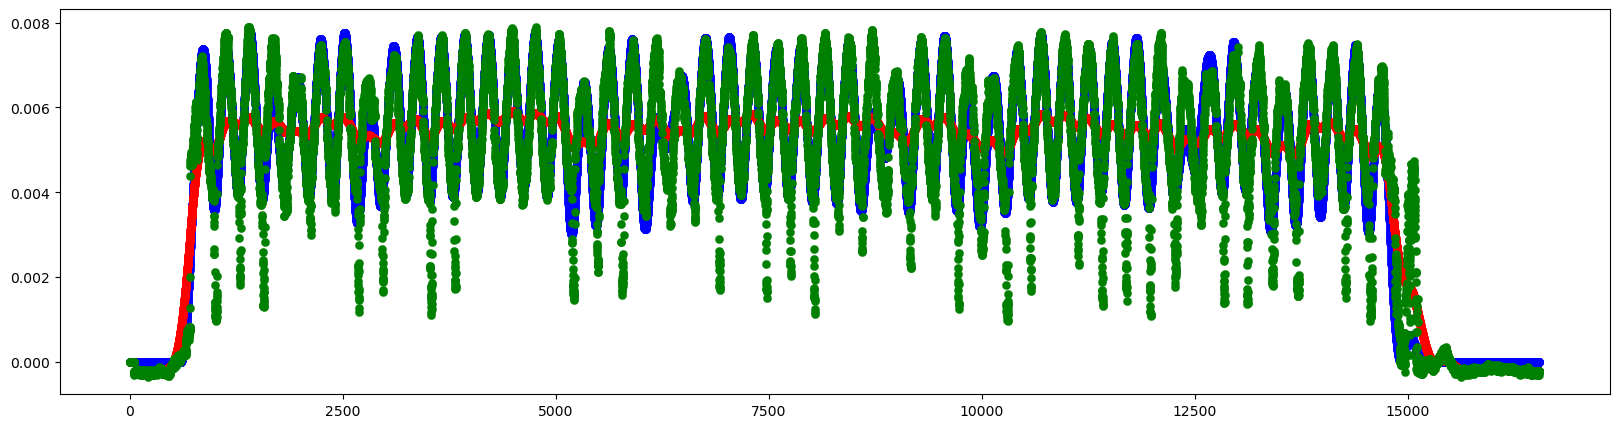

In [352]:
#tahmin edilen deltaposition normun ilk 5000 datası
arr = np.arange(0,len(at))
arr1 = np.arange(0,len(at))

#plt.scatter(arr,mag[:],color='red')

#target deltaposition ilk 5000 datası
plt.scatter(arr1[:],at[:,0],linewidth=0.2,color='blue')

plt.scatter(arr1[:],magg[:],linewidth=0.2,color='red')

plt.scatter(arr[:],megg[:],linewidth=0.2,color='green')

In [316]:
magg.shape

(16541,)

In [317]:
at[:,0].shape

(16541,)

In [318]:
megg.shape

(16541,)

In [353]:

wgt=at[:,0].reshape((len(at[:,0]), 1))
wpred=megg.reshape((len(megg), 1))
wfilt=magg.reshape((len(magg), 1))

mek=np.concatenate((wgt, wpred,wfilt), axis=1)   


from numpy import asarray
from numpy import savetxt
# define data

# save to csv file
savetxt('a-gtmag-predmag-filtpredmag.csv', mek, delimiter=',')

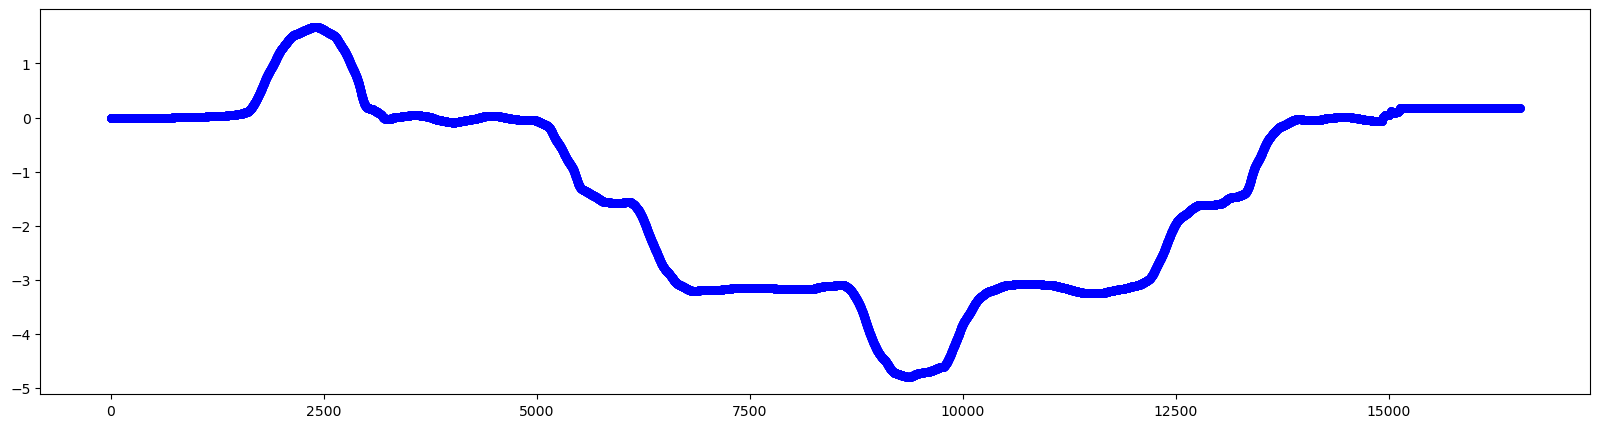

In [399]:
#ccc=1.43304571497088
#original heading is used
ccc=0
er=rct
arr = np.arange(0,len(er))
zp=np.zeros(len(er))

for i in arr:
    zp[i]=ccc+er[i]
    
    ccc=zp[i]
arr = np.arange(0,len(zp))




plt.scatter(arr[:],zp,linewidth=0.1, linestyle="-", c="b")  

In [377]:
arr = np.arange(0,len(at))
f=at.shape
uu=np.zeros((f[0], 1))
for i in range(f[0]-1):
    uu[i,0]=yyxyawt[i+1,0]-yyxyaw[i,0]


In [379]:
yawwe = np.zeros(len(yaww))

yawwe[0:47]=uu[0:47,0]
yawwe[47:16541]=yaw[:]

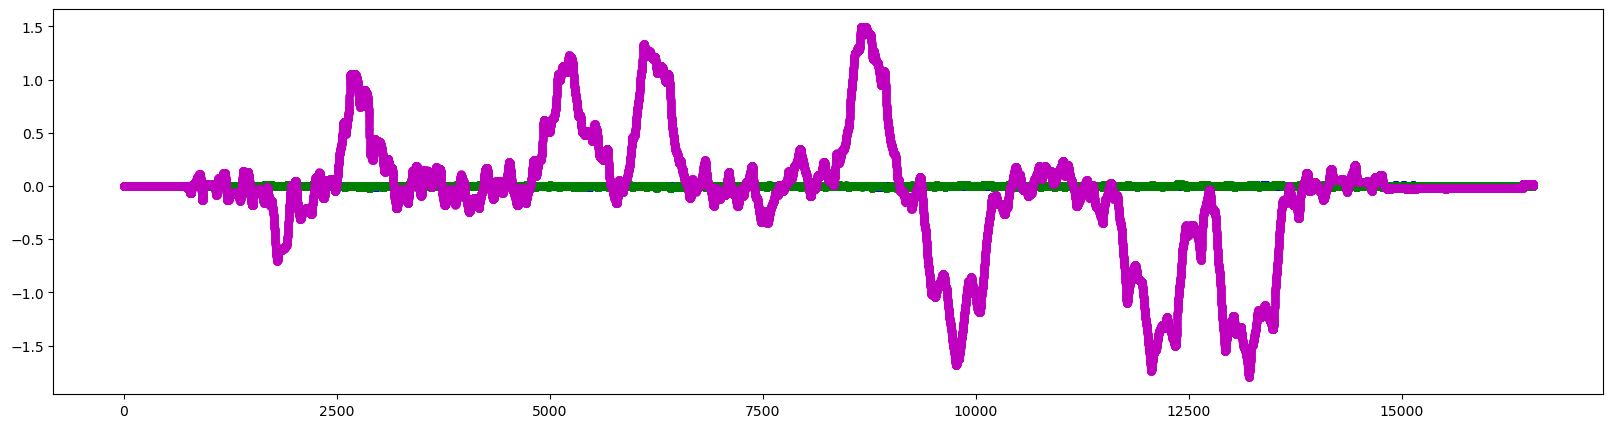

In [385]:
#tahmin  edilen delta yaw
arr = np.arange(0,len(yaww))

plt.scatter(arr,yaww,linewidth=0.2,color='red')# pred-filtered deltayaw

arr = np.arange(0,len(rct))
plt.scatter(arr[:],rct[:,0],linewidth=0.2, linestyle="-", c="b")#malinin datasının filtrelenmiş halindeki deltayaw


arr = np.arange(0,len(yawwe))
plt.scatter(arr[:],yawwe,linewidth=0.2, linestyle="-", c="g")#predicted deltayaw


arr = np.arange(0,len(uu))
plt.scatter(arr[:],uu,linewidth=0.2, linestyle="-", c="m")#original deltayaw

(16541,)

In [386]:

dyawgtmali=rct.reshape((len(rct), 1))
dpred_filtyaw=yaww.reshape((len(yaww), 1))
original_deltayaw=uu.reshape((len(uu), 1))
dpred_yaw=yawwe.reshape((len(yawwe), 1))
zzz=np.concatenate((dyawgtmali, dpred_filtyaw,original_deltayaw,dpred_yaw), axis=1)   


from numpy import asarray
from numpy import savetxt
# define data

# save to csv file
savetxt('a-deltayaw.csv', zzz, delimiter=',')

In [ ]:
A=np.max(out_seqt2)/np.max(yaw)

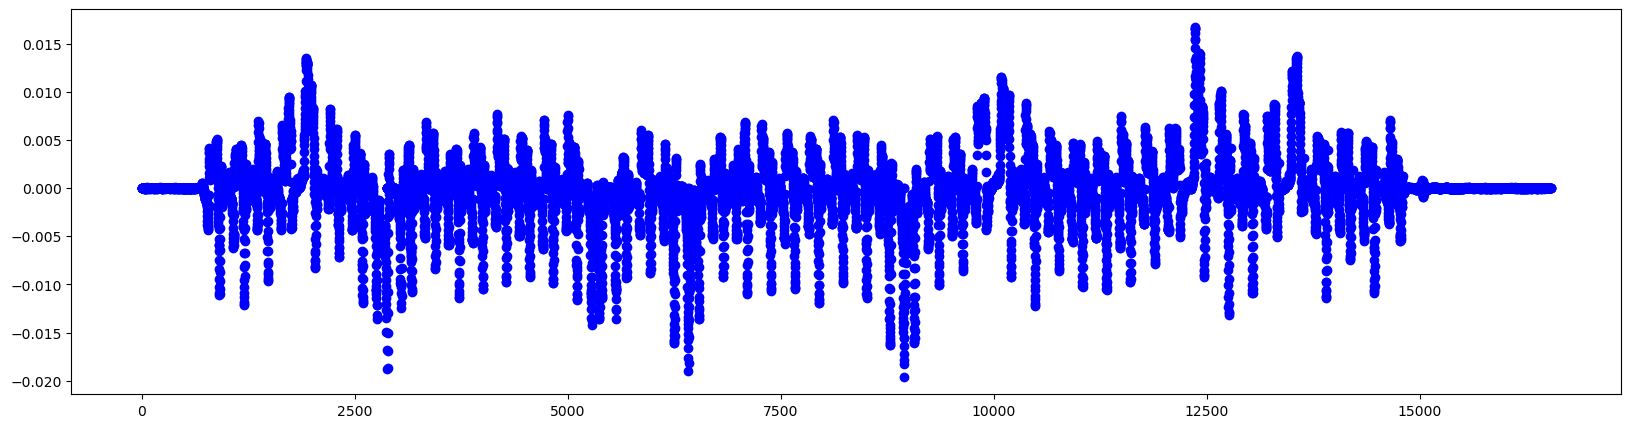

In [290]:
#yaw=yaw*A
#target deltayaw
arr = np.arange(0,len(out_seqt2))
plt.scatter(arr,out_seqt2,color='blue')


In [387]:
ccc=0
arr = np.arange(0,len(yawwe))
xxrte=np.zeros(len(yawwe))

for i in arr:
    xxrte[i]=ccc+yawwe[i]
    
    ccc=xxrte[i]
    

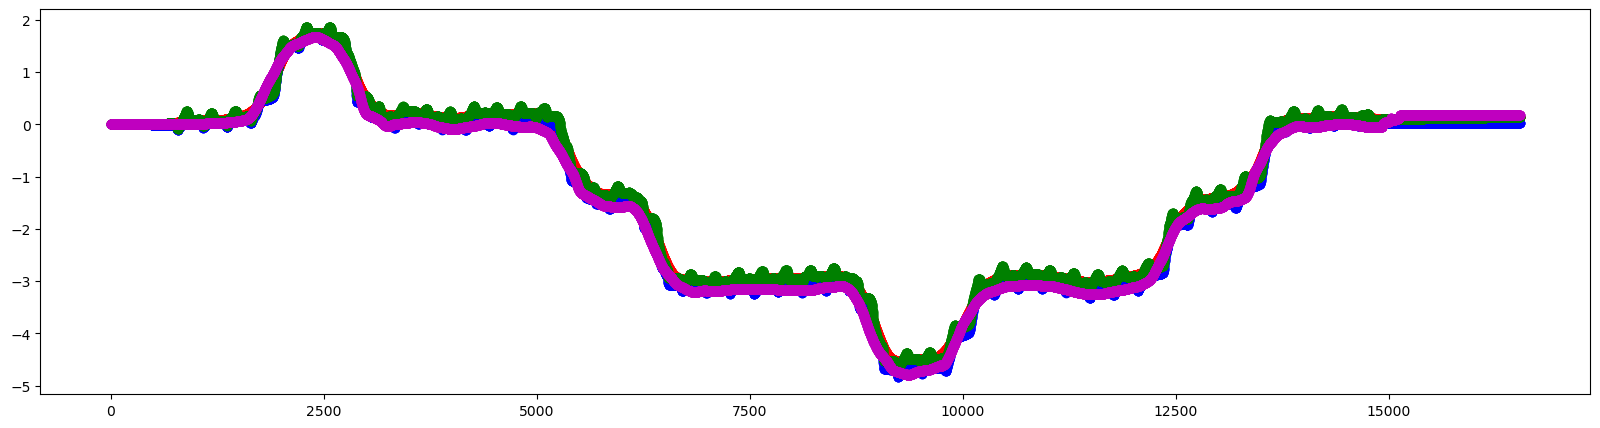

In [401]:
ccc=0
arr = np.arange(0,len(yaww))
xxrt=np.zeros(len(yaww))

for i in arr:
    xxrt[i]=ccc+yaww[i]
    
    ccc=xxrt[i]
    

plt.scatter(arr[:],xxrt,color='red') #tahmin edilen yaw(heading)
arr1 = np.arange(0,len(yyxtest[:,1]))
plt.scatter(arr1[:],at[:,1],color='blue')#target  yaw(heading)
plt.scatter(arr1[:],xxrte,color='g')#target  yaw(heading)
plt.scatter(arr1[:],zp,color='m')#target  yaw(heading)

In [389]:
predfiteredyaw=xxrt.reshape((len(xxrt), 1))
predyaw=xxrte.reshape((len(xxrte), 1))
original_yaw=at[:,1].reshape((len(at[:,1]), 1))
zp=zp.reshape((len(zp), 1))

zzz=np.concatenate((predfiteredyaw, predyaw,original_yaw,zp), axis=1)   


from numpy import asarray
from numpy import savetxt
# define data

# save to csv file
savetxt('a-yaw.csv', zzz, delimiter=',')

In [183]:
xxrt.shape

(16541,)

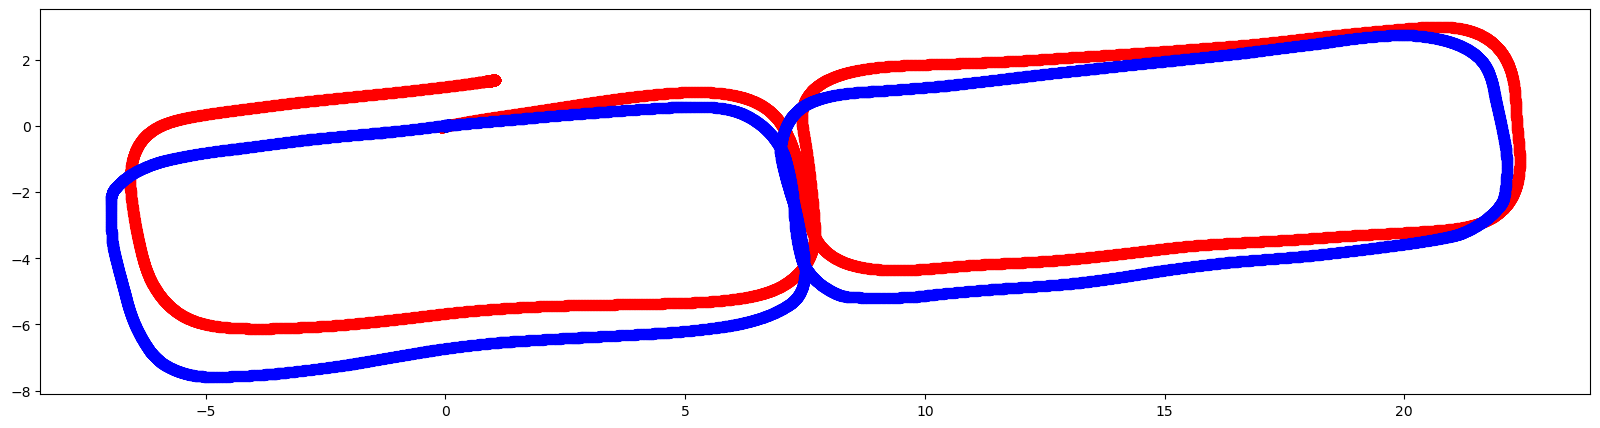

In [394]:
#yaw ve normu kullanarak x,y yi hesaplayıp çizdiriyoruz
arr = np.arange(0,len(xxrt))
sx=np.zeros(len(xxrt))
sy=np.zeros(len(xxrt))

for i in arr:
    sx[i]=magg[i]*math.cos(xxrt[i])
    sy[i]=magg[i]*math.sin(xxrt[i])

ddd=0
vvv=0
arr = np.arange(0,len(sx))
xft=np.zeros((len(sx),2))


for i in arr:
    xft[i,0]=ddd+sx[i]
    xft[i,1]=vvv+sy[i]
    
    ddd=xft[i,0]
    vvv=xft[i,1]
    plt.rcParams["figure.figsize"] = (20,5)

plt.scatter(xft[:,1],xft[:,0],linewidth=2, linestyle="-", c="r") #predicted (y,x grafiği) k

plt.scatter(yyxtest[:,1],yyxtest[:,0],linewidth=2, linestyle="-", c="b") #target(y,x grafiği)
#plt.scatter(yyxtests[:,1],yyxtests[:,0],linewidth=2, linestyle="-", c="k") #target(y,x grafiği)



In [395]:
#yaw ve normu kullanarak x,y yi hesaplayıp çizdiriyoruz

arr = np.arange(0,len(xxrt))
sx=np.zeros(len(xxrt))
sy=np.zeros(len(xxrt))

for i in arr:
    sx[i]=mag[i]*math.cos(xxrt[i])
    sy[i]=mag[i]*math.sin(xxrt[i])

ddd=0
vvv=0
arr = np.arange(0,len(sx))
xft=np.zeros((len(sx),2))


for i in arr:
    xft[i,0]=ddd+sx[i]
    xft[i,1]=vvv+sy[i]
    
    ddd=xft[i,0]
    vvv=xft[i,1]
f=xft.shape
xxft=np.zeros((f[0], 2))
for i in range(f[0]):
    xxft[i,0]=xft[i,0]*math.cos(math.pi/2.5)-xft[i,1]*math.sin(math.pi/2.5)
    xxft[i,1]=xft[i,0]*math.sin(math.pi/2.5)+xft[i,1]*math.cos(math.pi/2.5)

plt.rcParams["figure.figsize"] = (20,3)

plt.scatter(xxft[:,1],xxft[:,0],linewidth=2, linestyle="-", c="r") #predicted (y,x grafiği) k

plt.scatter(yyxtest[:,1],yyxtest[:,0],linewidth=2, linestyle="-", c="b") #target(y,x grafiği)

IndexError: index 16494 is out of bounds for axis 0 with size 16494

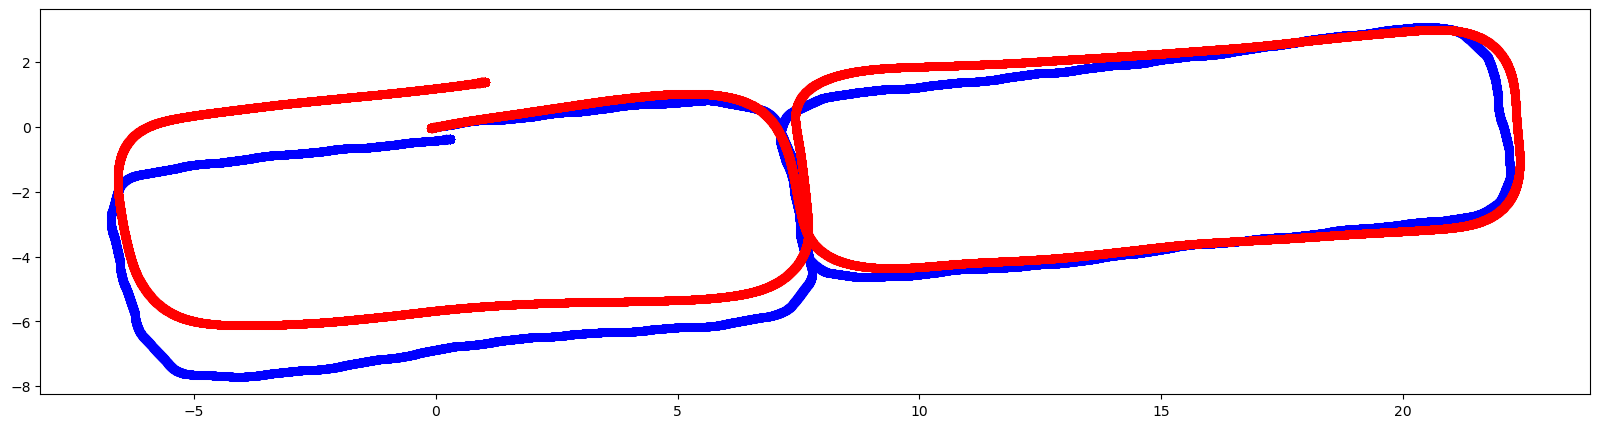

In [396]:

xxrt=yyxyawt
#yaw ve normu kullanarak x,y yi hesaplayıp çizdiriyoruz
arr = np.arange(0,len(xxrt))
sx=np.zeros(len(xxrt))
sy=np.zeros(len(xxrt))

for i in arr:
    sx[i]=at[i,0]*math.cos(xxrt[i])
    sy[i]=at[i,0]*math.sin(xxrt[i])

ddd=0
vvv=0
arr = np.arange(0,len(sx))
xsft=np.zeros((len(sx),2))


for i in arr:
    xsft[i,0]=ddd+sx[i]
    xsft[i,1]=vvv+sy[i]
    
    ddd=xsft[i,0]
    vvv=xsft[i,1]
f=xsft.shape
xxft=np.zeros((f[0], 2))
rotationAngle = 2.31 # in radians
for i in range(f[0]):
    xxft[i,0]=xsft[i,0]*math.cos(math.pi/rotationAngle)-xsft[i,1]*math.sin(math.pi/rotationAngle)
    xxft[i,1]=xsft[i,0]*math.sin(math.pi/rotationAngle)+xsft[i,1]*math.cos(math.pi/rotationAngle)
    plt.rcParams["figure.figsize"] = (20,5)

plt.scatter(xxft[:,1],xxft[:,0],linewidth=0.5, linestyle="-", c="b") #predicted (y,x grafiği) k
plt.scatter(xft[:,1],xft[:,0],linewidth=0.5, linestyle="-", c="r") #predicted (y,x grafiği) k


#plt.scatter(yyxtests[:,1],yyxtests[:,0],linewidth=0.5, linestyle="-", c="k") #target(y,x grafiği)


In [248]:
xft.shape

(16541, 2)

In [397]:
sve=np.concatenate((xft, xxft), axis=1)           

In [204]:
sve.shape

(16541, 4)

In [398]:
from numpy import asarray
from numpy import savetxt
# define data

# save to csv file
savetxt('a-predicted-groundtruth.csv', sve, delimiter=',')

In [194]:
xxft.shape

(16541, 2)

In [ ]:

plt.scatter(xft[:,0],xft[:,1],color='red') 



In [ ]:
#from tensorflow.keras.models import load_model
#model.save('localization.h5')  # creates a HDF5 file 'my_model.h5'


In [ ]:
import csv
f = open('path/to/csv_file', 'w')
writer = csv.writer(f)
writer.writerow(row)
f.close()
